In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json, model_from_json

In [11]:
dataset_path = '../data/'

pollen_test = pd.read_csv(dataset_path + 'pollen_test.csv')
pollen_train = pd.read_csv(dataset_path + 'pollen_train.csv')
pollen_type = pd.read_csv(dataset_path + 'pollen-type.csv')
submission_example = pd.read_csv(dataset_path + 'submission_example.csv')
weather_data = pd.read_csv(dataset_path + 'weather_data.csv')

In [12]:
pollen_train.head()

print(max(pollen_train.AMBROSIA))

1270


In [13]:
# fill nonexisting dates with 0 for every column

pollen_train['date'] = pd.to_datetime(pollen_train['date'])
pollen_train = pollen_train.set_index('date')
pollen_train = pollen_train.resample('D').sum()
pollen_train = pollen_train.reset_index()
pollen_train['date'] = pd.to_datetime(pollen_train['date'])

pollen_train.head()

,date,Unnamed: 0,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,...,PLANTAGO,PLATANUS,POACEAE,POPULUS,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE
0,2016-02-01,20824,0,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-02-02,21095,0,117,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,2016-02-03,21102,2,65,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,8,0
3,2016-02-04,21109,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2016-02-05,21116,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# pick 'date' and 'AMBROSIA' columns and change their name to 'ds' and 'y' respectively
# deep copy the dataframe

pollen_df = pollen_train.copy()

# change the column names
pollen_df['ds'] = pollen_df['date']
pollen_df['y'] = pollen_df['AMBROSIA']

pollen_df.drop(['Unnamed: 0', 'date', 'AMBROSIA'], axis=1, inplace=True)

pollen_df['cap'] = 2500
pollen_df['floor'] = 0

pollen_df.head()

,ACER,ALNUS,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,CHENOP/AMAR.,CORYLUS,CUPRESS/TAXA.,...,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE,ds,y,cap,floor
0,0,38,0,0,0,0,0,0,167,9,...,0,0,0,0,0,0,2016-02-01,0,2500,0
1,0,117,0,0,0,0,0,0,300,133,...,0,0,0,0,2,0,2016-02-02,0,2500,0
2,2,65,0,0,0,0,0,0,517,119,...,0,0,0,0,8,0,2016-02-03,0,2500,0
3,0,9,0,0,0,0,0,0,71,17,...,0,0,0,0,1,0,2016-02-04,0,2500,0
4,0,21,0,0,0,0,0,0,83,10,...,0,0,0,0,0,0,2016-02-05,0,2500,0


In [105]:
max(pollen_df['y'])

2445

## Model

In [106]:
# Split the data into train and test sets

train_df = pollen_df[:int(0.9*(len(pollen_df)))]
test_df = pollen_df[int(0.9*(len(pollen_df))):]

In [107]:
# define the model
model = prophet.Prophet(growth='logistic', interval_width=0.80, seasonality_mode = 'multiplicative', weekly_seasonality=False, daily_seasonality=False)
# fit the model
model.fit(train_df)

10:32:59 - cmdstanpy - INFO - Chain [1] start processing
10:33:02 - cmdstanpy - INFO - Chain [1] done processing


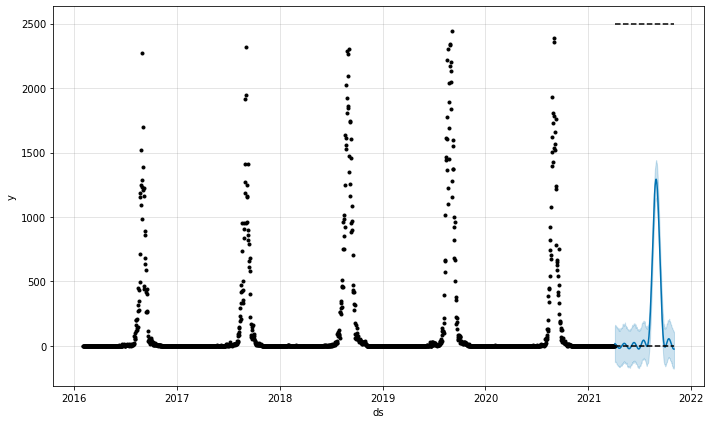

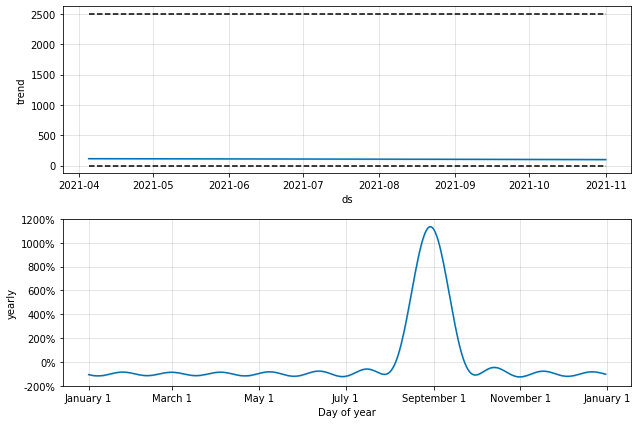

In [108]:
future = model.predict(test_df)
future['cap'] = 2500
future['floor'] = 0
fcst = model.predict(future)

fig = model.plot(fcst)
fig = model.plot_components(fcst)

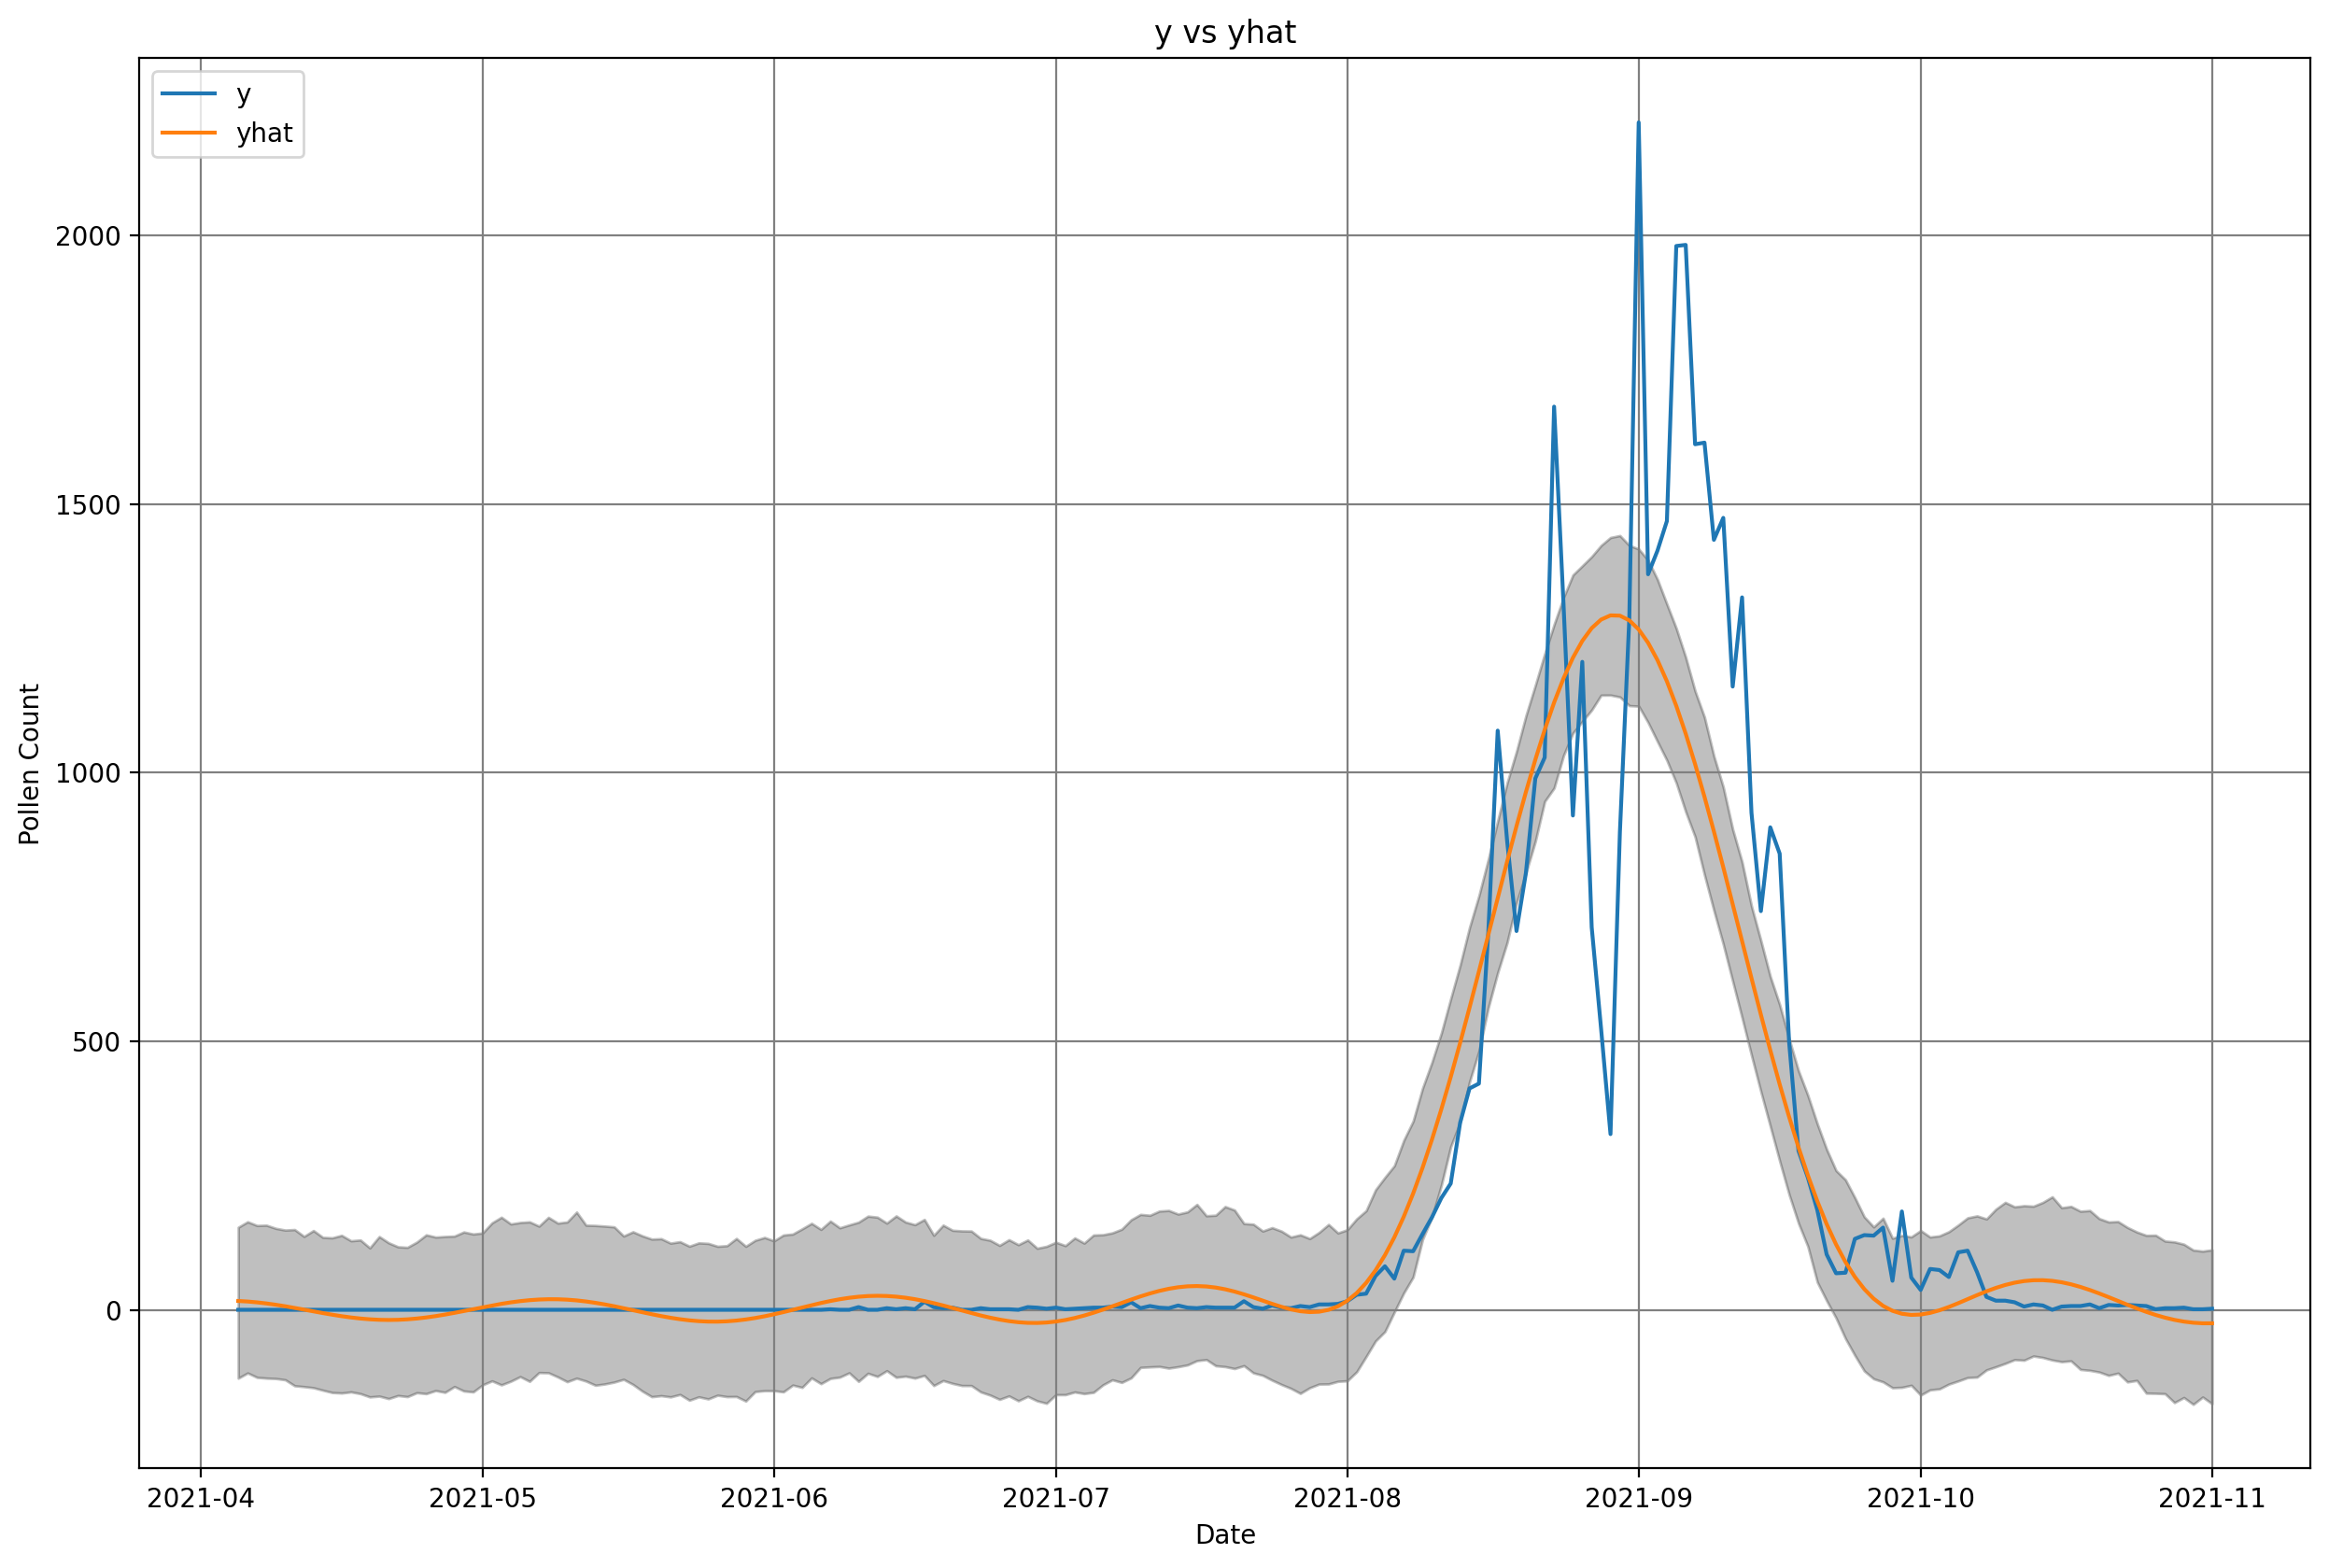

In [121]:
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(111)
ax.plot(test_df['ds'], test_df['y'], label='y')
ax.plot(fcst['ds'], fcst['yhat'], label='yhat')
ax.fill_between(fcst['ds'], fcst['yhat_lower'], fcst['yhat_upper'], color='k', alpha=0.25)
ax.set_title('y vs yhat')
ax.set_xlabel('Date')
ax.set_ylabel('Pollen Count')

ax.grid(which='major', axis='both', linestyle='-', color='grey')

plt.legend(loc='upper left')

plt.show()

# save plot to file
fig.savefig('../images/prophet_val.jpeg', dpi=fig.dpi)


## Save Model

In [110]:
# with open('../models/prophet.json', 'w') as fout:
    # fout.write(model_to_json(model))  # Save model

IndentationError: expected an indented block (2396640034.py, line 2)

In [132]:
future = model.make_future_dataframe(periods=1000)
future['cap'] = 2500
future['floor'] = 0
fcst = model.predict(future)

fig = model.plot(fcst)
fig.set_dpi(200)
plt.title('Pollen Forecast')
plt.xlabel('Date')
plt.ylabel('Pollen Count')

# save figure
fig.savefig('../images/prophet.jpg')

In [ ]:
fcst

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-02-01,93.024201,2500,0,-155.148083,164.089118,93.024201,93.024201,-0.903424,-0.903424,-0.903424,-0.903424,-0.903424,-0.903424,0.0,0.0,0.0,8.983948
1,2016-02-02,93.025674,2500,0,-151.949174,164.040305,93.025674,93.025674,-0.926636,-0.926636,-0.926636,-0.926636,-0.926636,-0.926636,0.0,0.0,0.0,6.824744
2,2016-02-03,93.027172,2500,0,-156.253496,160.685563,93.027172,93.027172,-0.951588,-0.951588,-0.951588,-0.951588,-0.951588,-0.951588,0.0,0.0,0.0,4.503621
3,2016-02-04,93.028695,2500,0,-163.143828,153.486526,93.028695,93.028695,-0.977447,-0.977447,-0.977447,-0.977447,-0.977447,-0.977447,0.0,0.0,0.0,2.098089
4,2016-02-05,93.030223,2500,0,-156.397063,157.622425,93.030223,93.030223,-1.003355,-1.003355,-1.003355,-1.003355,-1.003355,-1.003355,0.0,0.0,0.0,-0.312113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,2024-07-24,69.648863,2500,0,-153.004042,153.964151,66.148260,73.044775,-0.884230,-0.884230,-0.884230,-0.884230,-0.884230,-0.884230,0.0,0.0,0.0,8.063249
3097,2024-07-25,69.614850,2500,0,-161.508214,164.095114,66.107114,73.013423,-0.929690,-0.929690,-0.929690,-0.929690,-0.929690,-0.929690,0.0,0.0,0.0,4.894630
3098,2024-07-26,69.580854,2500,0,-155.600926,168.372569,66.066979,72.982170,-0.967755,-0.967755,-0.967755,-0.967755,-0.967755,-0.967755,0.0,0.0,0.0,2.243648
3099,2024-07-27,69.546874,2500,0,-160.032892,161.671453,66.027186,72.950887,-0.994396,-0.994396,-0.994396,-0.994396,-0.994396,-0.994396,0.0,0.0,0.0,0.389715
